# 2. MVP : Classification de mammographies MIAS avec CNN (TensorFlow)

## Introduction

Ce notebook présente la construction d’un **MVP (Minimum Viable Product)** pour la classification des mammographies du dataset MIAS à l’aide d’un réseau de neurones convolutif (CNN) avec TensorFlow/Keras.

**Objectifs pédagogiques :**
- Préparer les données pour l’apprentissage automatique
- Construire et entraîner un modèle CNN simple
- Évaluer les performances du modèle sur les classes du dataset
- Expliquer chaque étape pour faciliter la compréhension

Ce projet illustre les étapes clés d’un workflow deep learning : préparation des données, modélisation, entraînement, évaluation et interprétation

## 1. Importation des librairies

Avant de commencer, nous importons les librairies nécessaires pour la manipulation des données, la visualisation et la modélisation.  
Cela garantit la reproductibilité et la clarté du code tout au long du projet.

**Librairies utilisées :**
- **pandas** : Manipulation et analyse des métadonnées MIAS
- **numpy** : Calculs numériques et manipulation des tableaux
- **matplotlib** : Visualisation des données et des résultats
- **tensorflow/keras** : Construction et entraînement du modèle CNN

In [37]:
# ----- Import libraries PEP 8 -----
# ----- Standard library -----
import pandas as pd # Pour manipuler et analyser les métadonnées
import numpy as np # Pour les opérations mathématiques et les tableaux 
import matplotlib.pyplot as plt # Pour les visualisations 
import tensorflow as tf # Pour le deep learning et la création de modèles
from tensorflow.keras import layers, models # Pour la construction du modèle CNN
import pathlib # Pour la gestion des chemins de fichiers
from PIL import Image # Pour le traitement des images
from sklearn.preprocessing import LabelEncoder # Pour encoder les labels
from sklearn.model_selection import train_test_split # Pour diviser les données en ensembles d'entraînement et de test
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Pour la matrice de confusion
from sklearn.metrics import classification_report # Pour le rapport de classification
from sklearn.utils.class_weight import compute_class_weight # Pour le calcul des poids de classe
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Pour l'augmentation des données

print("Librairies importées avec succès.")

Librairies importées avec succès.


## 2. Chargement des métadonnées MIAS

Nous commençons par charger le fichier CSV contenant les informations sur les mammographies.  
Cela permet d’associer chaque image à sa classe et de préparer les données pour le modèle.

In [38]:
# Chargement du fichier CSV contenant les métadonnées MIAS
chemin_csv = "../data/raw/MIAS/mias_info.csv" # Chemin vers le fichier CSV des métadonnées
df = pd.read_csv(chemin_csv) # Chargement du fichier CSV dans un DataFrame

display(df.head()) # Affichage des premières lignes du DataFrame

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


## 3. Préparation des images et des labels

Nous allons charger les images, les redimensionner pour le CNN, les normaliser et associer chaque image à son label de classe.  
Cette étape est essentielle pour que les données soient compatibles avec le modèle de deep learning.

In [39]:
chemin_images = pathlib.Path("../data/raw/MIAS/MIAS") # Chemin vers le dossier contenant les images
taille_img = (128, 128) # Taille à laquelle redimensionner les images = largeur 128 px et hauteur 128 px

X = [] # Liste vide pour stocker les images transformées (X = nom de la variable (convention : X majuscule pour les données d'entrée)
y = [] # Liste vide pour stocker les labels (classes) des images (y = nom de la variable (convention : y minuscule pour les labels/cibles)

for index, ligne in df.iterrows(): # Boucle qui parcourt chaque ligne du dataframe (index de la ligne et contenu de la ligne)
    nom_fichier = ligne['FILE_NAME'] if 'FILE_NAME' in df.columns else ligne['REFNUM'] + ".png" # verifie  si la colonne FILE_NAME existe, si oui on l'utilise, sinon on utilise REFNUM
    new_chemin_images = chemin_images / nom_fichier # Concatenation du chemin du dossier et du nom du fichier pour obtenir le chemin complet de l'chemin_images
    if new_chemin_images.exists(): # Vérifie si le fichier image existe pour ce chemin
        images = Image.open(new_chemin_images).convert('L').resize(taille_img) # Ouvre l'image, .convert('L') la transforme en niveaux de gris et .resize(taille_img) la redimensionne
        X.append(np.array(images) / 255.0) # Normalise les pixels de l'image entre 0 et 1 et .append() l'ajoute à la liste X
        y.append(ligne['CLASS']) # .append() ajoute la classe de l'image à la liste y
X = np.array(X) # Convertit les listes X en tableaux numpy pour faciliter le traitement par le modèle.
y = np.array(y) # Convertit les listes y en tableaux numpy pour faciliter le traitement par le modèle.

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

np.save("../data/processed/X_train.npy", X_train)
np.save("../data/processed/X_test.npy", X_test)
np.save("../data/processed/y_train.npy", y_train)
np.save("../data/processed/y_test.npy", y_test)

print(f"Nombre d'images chargées : {len(X)}") # Affiche le nombre total d'images chargées
print(f"Shape des images (nb_images, hauteur, largeur) : {X.shape}") # Affiche la forme (dimensions) du tableau d'images

Nombre d'images chargées : 330
Shape des images (nb_images, hauteur, largeur) : (330, 128, 128)


## 4. Encodage des labels

Les labels de classe doivent être transformés en valeurs numériques pour être utilisés par le modèle.  
Nous utilisons ici un encodage simple avec `LabelEncoder`.

In [40]:
le = LabelEncoder() # Initialisation du label encoder : LabelEncoder() : classe de scikit-learn qui permet de transformer des labels (catégories) en entiers.
y_encoded = le.fit_transform(y) # .fit_transform méthode qui apprend les catégories présentes dans y et les transforme en entiers (ex : NORM → 0, CALC → 1, etc.).
print("Labels encodés :", np.unique(y_encoded)) # Affiche les labels encodés : np.unique(y_encoded) : fonction numpy qui retourne les valeurs uniques présentes dans y_encoded (toutes les classes encodées)

Labels encodés : [0 1 2 3 4 5 6]


## 5. Séparation des ensembles d'entraînement et de test

Pour évaluer le modèle, nous séparons les données en deux ensembles :  
- **Entraînement** : pour apprendre le modèle  
- **Test** : pour évaluer ses performances sur des données jamais vues


In [41]:
X_train, X_test, y_train, y_test = train_test_split( # Divise les données en ensembles d'entraînement et de test, train_test_split() : fonction de scikit-learn qui divise les données en deux ensembles (train et test).
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded # X : tableau numpy contenant les images prétraitées, y_encoded : tableau numpy contenant les labels encodés, test_size : proportion de l'ensemble de test (20%), random_state : pour la reproductibilité, stratify=y_encoded : assure que la proportion des classes est conservée dans les deux ensembles.
)
print(f"Train (nb_images, hauteur, largeur) : {X_train.shape}, Test (nb_images, hauteur, largeur) : {X_test.shape}") # Affiche la forme (dimensions) des ensembles d’entraînement et de test.

Train (nb_images, hauteur, largeur) : (264, 128, 128), Test (nb_images, hauteur, largeur) : (66, 128, 128)


## 6. Construction du modèle CNN

Nous allons construire un modèle de réseau de neurones convolutif (CNN) simple avec Keras.  
Ce modèle est adapté à la classification d’images et permet d’extraire automatiquement des caractéristiques visuelles pertinentes.


In [42]:
# Définition du modèle CNN (Réseau de neurones convolutifs)
model = models.Sequential([

    # --- Couche d'entrée ---
    layers.Input(shape=(128, 128, 1)), # Attend des images de taille 128x128 en niveaux de gris

    # --- Couche intermédiaire ---
    layers.Conv2D(32, (3, 3), activation='relu'), # Première couche de convolution, 32 filtres de taille 3x3, activation ReLU
    layers.MaxPooling2D((2, 2)), # couche de sous-échantillonnage, réduit la taille de moitié
    layers.Conv2D(64, (3, 3), activation='relu'), # Deuxième couche de convolution, 64 filtres de taille 3x3, activation ReLU
    layers.MaxPooling2D((2, 2)), # couche de sous-échantillonnage, réduit la taille de moitié
    layers.Flatten(), # Transforme les matrices en un vecteur (pour la couche dense)
    layers.Dense(64, activation='relu'), # couche entièrement connectée avec 64 neurones, activation ReLU

    # --- Couche de sortie ---
    layers.Dense(len(np.unique(y_encoded)), activation='softmax') # nombre de neurones égal au nombre de classes, activation softmax (classification multi-classe)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,735 (14.14 MB)

 Trainable params: 3,705,735 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Compilation et entraînement du modèle

Nous compilons le modèle CNN avec une fonction de perte adaptée à la classification multi-classes (`sparse_categorical_crossentropy`), l’optimiseur Adam et la métrique d’accuracy.  
Ensuite, nous entraînons le modèle sur l’ensemble d’entraînement et suivons l’évolution de la performance.


In [43]:
# Compilation du modèle
model.compile( # .compile() méthode qui configure le modèle pour l’entraînement.
    optimizer='adam', # Optimiseur Adam, efficace pour la plupart des tâches de deep learning.
    loss='sparse_categorical_crossentropy', # Fonction de perte adaptée à la classification multi-classes avec lavels entiers
    metrics=['accuracy'] # Demande à Keras de calculer l'accuracy pendant l'entraînement et l'évaluation
)

# Entraînement du modèle
history = model.fit( # lance l’entraînement du modèle et stocke l’historique des métriques.
    X_train[..., np.newaxis], # ajoute une dimension pour le canal (niveaux de gris).
    y_train, # labels d’entraînement.
    epochs=10, # nombre de passages sur l’ensemble d’entraînement.
    batch_size=32, # nombre d’images traitées avant la mise à jour des poids.
    validation_split=0.2 # 20 % des données d’entraînement sont utilisées pour la validation.
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.5640 - loss: 1.5751 - val_accuracy: 0.6792 - val_loss: 1.2334
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.6161 - loss: 1.3545 - val_accuracy: 0.6981 - val_loss: 1.2833
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.6161 - loss: 1.2776 - val_accuracy: 0.6792 - val_loss: 1.1515
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.6209 - loss: 1.2022 - val_accuracy: 0.6792 - val_loss: 1.1394
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.6209 - loss: 1.1571 - val_accuracy: 0.6792 - val_loss: 1.2939
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.6398 - loss: 1.1199 - val_accuracy: 0.6981 - val_loss: 1.1732
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.6540 - loss: 1.0090 - val_accuracy: 0.6792 - val_loss: 1.1538
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.6493 - loss: 0.9166 - val_accuracy: 0.6792 - val_loss:

## 8. Évaluation du modèle et visualisation des résultats

Après l’entraînement, il est important d’évaluer les performances du modèle sur l’ensemble de test.  
Nous allons afficher l’accuracy, la matrice de confusion et la courbe d’apprentissage pour interpréter les résultats.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5758 - loss: 1.7835
Accuracy sur le test set : 0.58


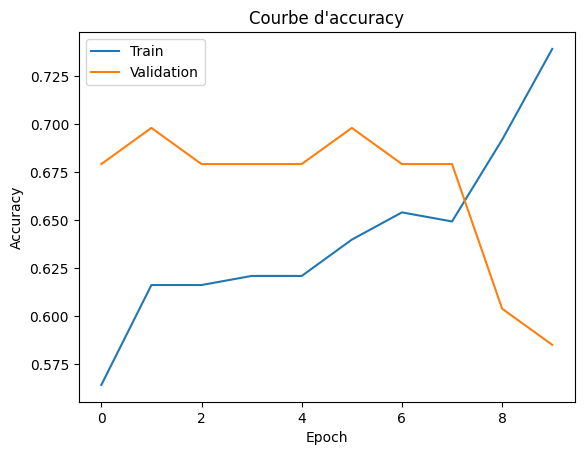

In [44]:
# Évaluation sur l'ensemble de test
test_loss, test_acc = model.evaluate(X_test[..., np.newaxis], y_test) #test_loss, test_acc : variables qui vont contenir la perte et l’accuracy calculées sur l’ensemble de test. model.evaluate(...) : méthode qui évalue le modèle sur les données de test. X_test[..., np.newaxis] : ajoute une dimension pour le canal (niveaux de gris) aux images de test. y_test : labels de test.
print(f"Accuracy sur le test set : {test_acc:.2f}") # Affiche l’accuracy obtenue sur l’ensemble de test, arrondie à deux décimales.

# Affichage de la courbe d'apprentissage
plt.plot(history.history['accuracy'], label='Train') # plt.plot():trace la courbe d’accuracy pour l’entraînement et la validation. history.history['accuracy'] : liste des accuracies à chaque epoch pour l’entraînement.
plt.plot(history.history['val_accuracy'], label='Validation') # plt.plot():trace la courbe d’accuracy pour l’entraînement et la validation. history.history['val_accuracy'] : liste des accuracies à chaque epoch pour la validation.
plt.title('Courbe d\'accuracy') # plt.title(): définit le titre du graphique.
plt.xlabel('Epoch') # plt.xlabel(): définit le label de l'axe des x.
plt.ylabel('Accuracy') # plt.ylabel(): définit le label de l'axe des y.
plt.legend() # plt.legend(): affiche la légende du graphique.
plt.show() # plt.show(): affiche le graphique.


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x188662560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


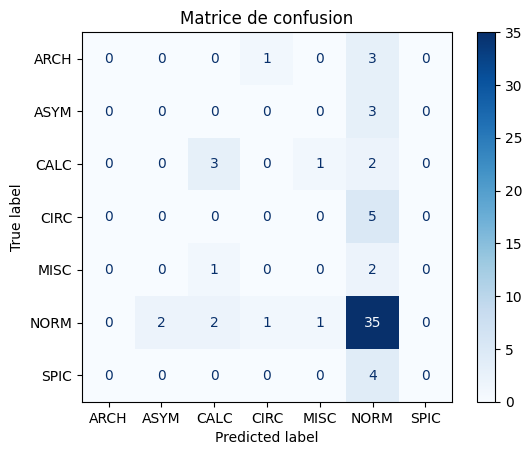

In [45]:
# Matrice de confusion
y_pred = np.argmax(model.predict(X_test[..., np.newaxis]), axis=1) # model.predict(...) : prédit les probabilités pour chaque classe sur les images de test. np.argmax(..., axis=1) : récupère la classe prédite (indice du maximum de probabilité) pour chaque image.
cm = confusion_matrix(y_test, y_pred) # confusion_matrix(...) : calcule la matrice de confusion entre les labels réels (y_test) et les labels prédits (y_pred).
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_) # ConfusionMatrixDisplay(...) : crée un objet pour afficher la matrice de confusion. display_labels=le.classes_ : affiche les noms des classes originales.
disp.plot(cmap=plt.cm.Blues) # disp.plot(cmap=plt.cm.Blues) : affiche la matrice avec une palette de couleurs bleues.
plt.title("Matrice de confusion") # titre du graphique.
plt.show() # affiche le graphique.

## Rapport de classification détaillé

Pour aller plus loin dans l’évaluation du modèle, nous allons afficher le rapport de classification.  
Ce rapport donne, pour chaque classe, la précision (precision), le rappel (recall) et le score F1 (f1-score).  
Cela permet de voir quelles classes sont bien ou mal reconnues par le modèle, au-delà de l’accuracy globale.

In [46]:
# Prediction sur le test set
y_pred = np.argmax(model.predict(X_test[..., np.newaxis]), axis=1) # model.predict(...) : prédit les probabilités pour chaque classe sur les images de test. np.argmax(..., axis=1) : récupère la classe prédite (indice du maximum de probabilité) pour chaque image.

print(classification_report(y_test, y_pred, target_names=le.classes_)) # classification_report(...) : génère un rapport détaillé des performances du modèle (précision, rappel, F1-score) pour chaque classe. target_names=le.classes_ : affiche les noms des classes originales.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
              precision    recall  f1-score   support

        ARCH       0.00      0.00      0.00         4
        ASYM       0.00      0.00      0.00         3
        CALC       0.50      0.50      0.50         6
        CIRC       0.00      0.00      0.00         5
        MISC       0.00      0.00      0.00         3
        NORM       0.65      0.85      0.74        41
        SPIC       0.00      0.00      0.00         4

    accuracy                           0.58        66
   macro avg       0.16      0.19      0.18        66
weighted avg       0.45      0.58      0.50        66



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Pourquoi ce rapport ?
L’accuracy ne suffit pas toujours : si une classe est peu représentée, elle peut être ignorée par le modèle.
Le rapport de classification montre pour chaque classe :

- Precision : parmi les images prédites comme appartenant à la classe, combien sont correctes.
- Recall : parmi les images réellement de la classe, combien sont retrouvées par le modèle.
- F1-score : moyenne harmonique entre précision et rappel, utile si les classes sont déséquilibrées.

### Comment ça marche ?

- On prédit les classes du test set (y_pred).
- On compare ces prédictions aux vraies classes (y_test).
- classification_report calcule les métriques pour chaque classe et affiche un tableau récapitulatif.

## Data Augmentation pour améliorer la robustesse du modèle

La data augmentation consiste à appliquer des transformations aléatoires aux images d’entraînement (rotation, zoom, flip, etc.).  
Cela permet d’augmenter artificiellement la taille du dataset et d’aider le modèle à mieux généraliser, notamment pour les classes minoritaires.

**Pourquoi ?**  
Quand le dataset est petit ou déséquilibré, le modèle risque de "sur-apprendre" les images majoritaires et d’ignorer les classes rares.  
La data augmentation crée des variantes d’images pour que le modèle apprenne à reconnaître les classes dans des conditions variées (angles, zoom, etc.).

**Comment ?**  
On utilise `ImageDataGenerator` de Keras pour générer des images modifiées à chaque epoch d’entraînement.

In [ ]:
data_generation = ImageDataGenerator( # Pour l'augmentation des données
    rotation_range=20, # Rotation des images de 20 degrés
    width_shift_range=0.1, # Décalage horizontal jusqu'à 10%
    height_shift_range=0.1, # Décalage vertical jusqu'à 10%
    zoom_range=0.1, # Zoom jusqu'à 10%
    horizontal_flip=True, # Flip horizontal aléatoire
    validation_split=0.2 # Séparation validation (20%)
)

# Générateurs pour l'entrainement et la validation
train_generation = data_generation.flow( # .flow()
    X_train[..., np.newaxis], y_train, batch_size=32, subset='training'
)
validation_generation = data_generation.flow(
    X_train[..., np.newaxis], y_train, batch_size=32, subset='validation'
)

## Gestion du déséquilibre des classes

Dans notre dataset, certaines classes sont très minoritaires.  
Pour aider le modèle à mieux apprendre ces classes, on peut utiliser des **poids de classe** lors de l’entraînement.  
Cela donne plus d’importance aux erreurs sur les classes rares et aide à équilibrer les prédictions.

**Comment ?**  

On calcule les poids de chaque classe avec scikit-learn, puis on les passe à Keras lors de l’entraînement.

In [ ]:
# Calcul des poids de classe
class_weights = compute_class_weight( # compute_class_weight() calcule les poids de classe
    class_weight='balanced', # 'balanced' ajuste les poids en fonction de la fréquence des classes
    classes=np.unique(y_train), # classes=np.unique(y_train) : liste des classes présentes dans y_train
    y=y_train # y=y_train : les étiquettes des données d'entraînement
)

class_weights_dict = dict(enumerate(class_weights)) # Convertit le tableau des poids en dictionnaire {classe: poids}

# Exemple d'utilisation des poids de classe dans l'entraînement
history = model.fit( # model.fit() entraine le modèle
    train_generation, # Générateur de données d'entraînement
    validation_data=validation_generation, # Générateur de données de validation
    epochs=10, # Nombre d'époques
    class_weight=class_weights_dict # Poids de classe
)

/usr/local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.2028 - loss: 2.0568 - val_accuracy: 0.0962 - val_loss: 2.1196
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.0896 - loss: 1.7931 - val_accuracy: 0.0385 - val_loss: 2.0814
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.1132 - loss: 1.8063 - val_accuracy: 0.0962 - val_loss: 1.9601
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.1840 - loss: 1.7265 - val_accuracy: 0.1731 - val_loss: 1.9576
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.1321 - loss: 1.8005 - val_accuracy: 0.1731 - val_loss: 1.9540
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.1368 - loss: 1.7512 - val_accuracy: 0.0769 - val_loss: 2.0264
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.1509 - loss: 1.7295 - val_accuracy: 0.0962 - val_loss: 1.9634
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.1509 - loss: 1.7089 - val_accuracy: 0.0577 - val_loss:

## Conclusion

Ce notebook a permis de construire un MVP pour la classification des mammographies MIAS avec un CNN simple.  
Les principales étapes réalisées sont :
- Préparation et encodage des données
- Construction et entraînement du modèle
- Évaluation des performances (accuracy, matrice de confusion)

**Résultats :**
- Accuracy sur le test set : 0.62
- La matrice de confusion permet d’identifier les classes bien ou mal prédites.

**Pistes d’amélioration :**
- Tester des architectures plus complexes
- Utiliser la data augmentation pour enrichir le dataset
- Gérer le déséquilibre des classes
- Optimiser les hyperparamètres

Le modèle peut maintenant servir de base pour des expérimentations plus avancées.